# Project 001 UCSD Data Science Visualization Bootcamp
* Noreen Malik 😃
* Rene Venema("dutch") 🐱
* John Warlop 🦁
* Alex Wooten 🏄

😛😳😗😓🙉😸🙈🙊😽💀💢💥✨💏👫👄👃👀👛👛🗼🔮🔮🎄🎅👻

## Dependencies -- imports


In [1]:
import pandas as pd
from sodapy import Socrata #pip install socrata
import plotly.plotly as py #pip installl plotly
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
import json


## Constants -- API Keys, etc

In [2]:
# Read in API(.gitignore file has entry for api_keys.json file)
API_endpoint = "https://data.cms.gov/resource/spmh-qjdv.json" #2015 data


IRS_DATAFRAME_PICKLE = 'df_irs.pkl'
with open('api_keys.json') as json_data:
    api_keys = json.load(json_data)

# Socrata Section
socrata_domain = "data.cms.gov"
socrata_dataset_identifier = "spmh-qjdv"
socrata_token = api_keys['socrata']['App_Token']
#print(api_keys['socrata']['App_Token'])
#print(api_keys['socrata']['Secret_Token'])
#print(api_keys['zillow']['ZWSID'])



## Functions 


In [3]:
def return_irs_df(file_name):
    #return the pickled dataframe for irs data
    df_irs = pd.read_pickle(file_name)
    return(df_irs)

# IRS Dataframe
[Link to Documentation](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi) |
[SOI Tax Stats](https://www.irs.gov/statistics/soi-tax-stats-statistical-methodology) | [Data Cleaning of IRS Data](https://docs.google.com/document/d/1kNd1S_Ufgy0pIjJSjLDHba8y-pK8OYe47iAGeamH04E/edit?usp=sharing)

In [4]:
# Dataframe columns are: ST(State), Zip(Zip Code), AGI(Adjusted Gross Income),TtlR(Total Returns)
# TtlSR(Total Single Returns), TtlJR(Total Joint Returns), Eld(Number of Elderly Returns -- over 60 years old)
# AGI column is agreegated: 
# 1=> [1-25000), 2=> [25000-50000), 3=> [50000-75000), 4=> [75000-100000),
# 5=> [100000,200000), 6=> [200000-]
df_irs = return_irs_df(IRS_DATAFRAME_PICKLE)
df_irs.columns

Index(['ST', 'Zip', 'AGI', 'TtlR', 'TtlSR', 'TtlJR', 'Eld'], dtype='object')

# Dataframe - Medicare csv/api (dutch)
[Link to Documentation](https://dev.socrata.com/foundry/data.cms.gov/ehrv-m9r6)


In [5]:
#main_df = pd.read_csv("main_data_cleaned.csv")
#main_df.head()
client = Socrata(socrata_domain, socrata_token)
results = client.get(socrata_dataset_identifier, limit = 100000000) #default for limit (integer) = 1000
main_df = pd.DataFrame.from_dict(results)
main_df.head()
# Convert column datatypes
## Convert to float
col1 = ["average_covered_charges","average_medicare_payments","average_total_payments"]
main_df[col1] = main_df[col1].astype("float")
## Convert to integer
col2 = ["provider_id","provider_zip_code","total_discharges"]
main_df[col2] = main_df[col2].astype("int")
# Export data to csv file
main_df.to_csv("main data cleaned.csv", encoding = "utf-8-sig", index = False)

In [6]:
# Import data from csv
main_df = pd.read_csv("main data cleaned.csv")

# Avg Cost Per Provider (Alex)

In [66]:
# ACC = Average Covered Charges
#     The provider's average charge for services covered by Medicare for all discharges
#     in the DRG. These will vary from
#     hospital to hospital because of differences in hospital charge structures.
# ATP = Average Total Payments
#     The average of Medicare payments to the provider for the DRG including the
#     DRG amount, teaching,  disproportionate 
#     share, capital, and outlier payments for all cases. Also included 
#     are co-payment and deductible amounts that the 
#     patient is responsible for (average_medicare_payments)
# AMP = Average Medicare Payments
#     average_medicare_payments_2?
#     Not sure what this column represents


# Create a Groupby based on Provider Id and Provider name
# Calculate mean values in ACC, ATP, AMP (or we may just be interested in what
# the patient pays)
# I could also sum up the average value of payments by patient and by insurance
# to see average total value provider charges

cost_df = main_df[["provider_id", "provider_name", "provider_zip_code", "average_covered_charges",
                   "average_total_payments", "average_medicare_payments"]]

provider_group = cost_df.groupby(["provider_id", "provider_name", "provider_zip_code"])
avg_cost_group = round(provider_group.mean(),2)
avg_cost_group.columns



Index(['average_covered_charges', 'average_total_payments',
       'average_medicare_payments'],
      dtype='object')

In [67]:
# Most Expensive Hospitals based on out-of-pocket charges

avg_cost_group["average_patient_payment"] = (avg_cost_group["average_total_payments"]-
                                             avg_cost_group["average_medicare_payments"])
# Sort values in descending order and view DataFrame
# avg_cost_group.sort_values(by=["average_patient_payment"], ascending=False).head()

,,,average_covered_charges,average_total_payments,average_medicare_payments,average_patient_payment
provider_id,provider_name,provider_zip_code,,,,
140100,MIDWESTERN REGION MED CENTER,60099,109464.69,49820.77,13068.77,36752.00
670092,WALNUT HILL MEDICAL CENTER,75231,62346.49,37598.19,8486.33,29111.86
110233,SOUTHEASTERN REGIONAL MEDICAL CENTER,30265,109810.08,38391.15,20501.54,17889.61
50541,KAISER FOUNDATION HOSPITAL - REDWOOD CITY,94063,44147.75,25823.96,10467.44,15356.52
670096,"BAY AREA REGIONAL MEDICAL CENTER, LLC",77598,45476.72,18572.35,6051.55,12520.80


<Container object of 10 artists>

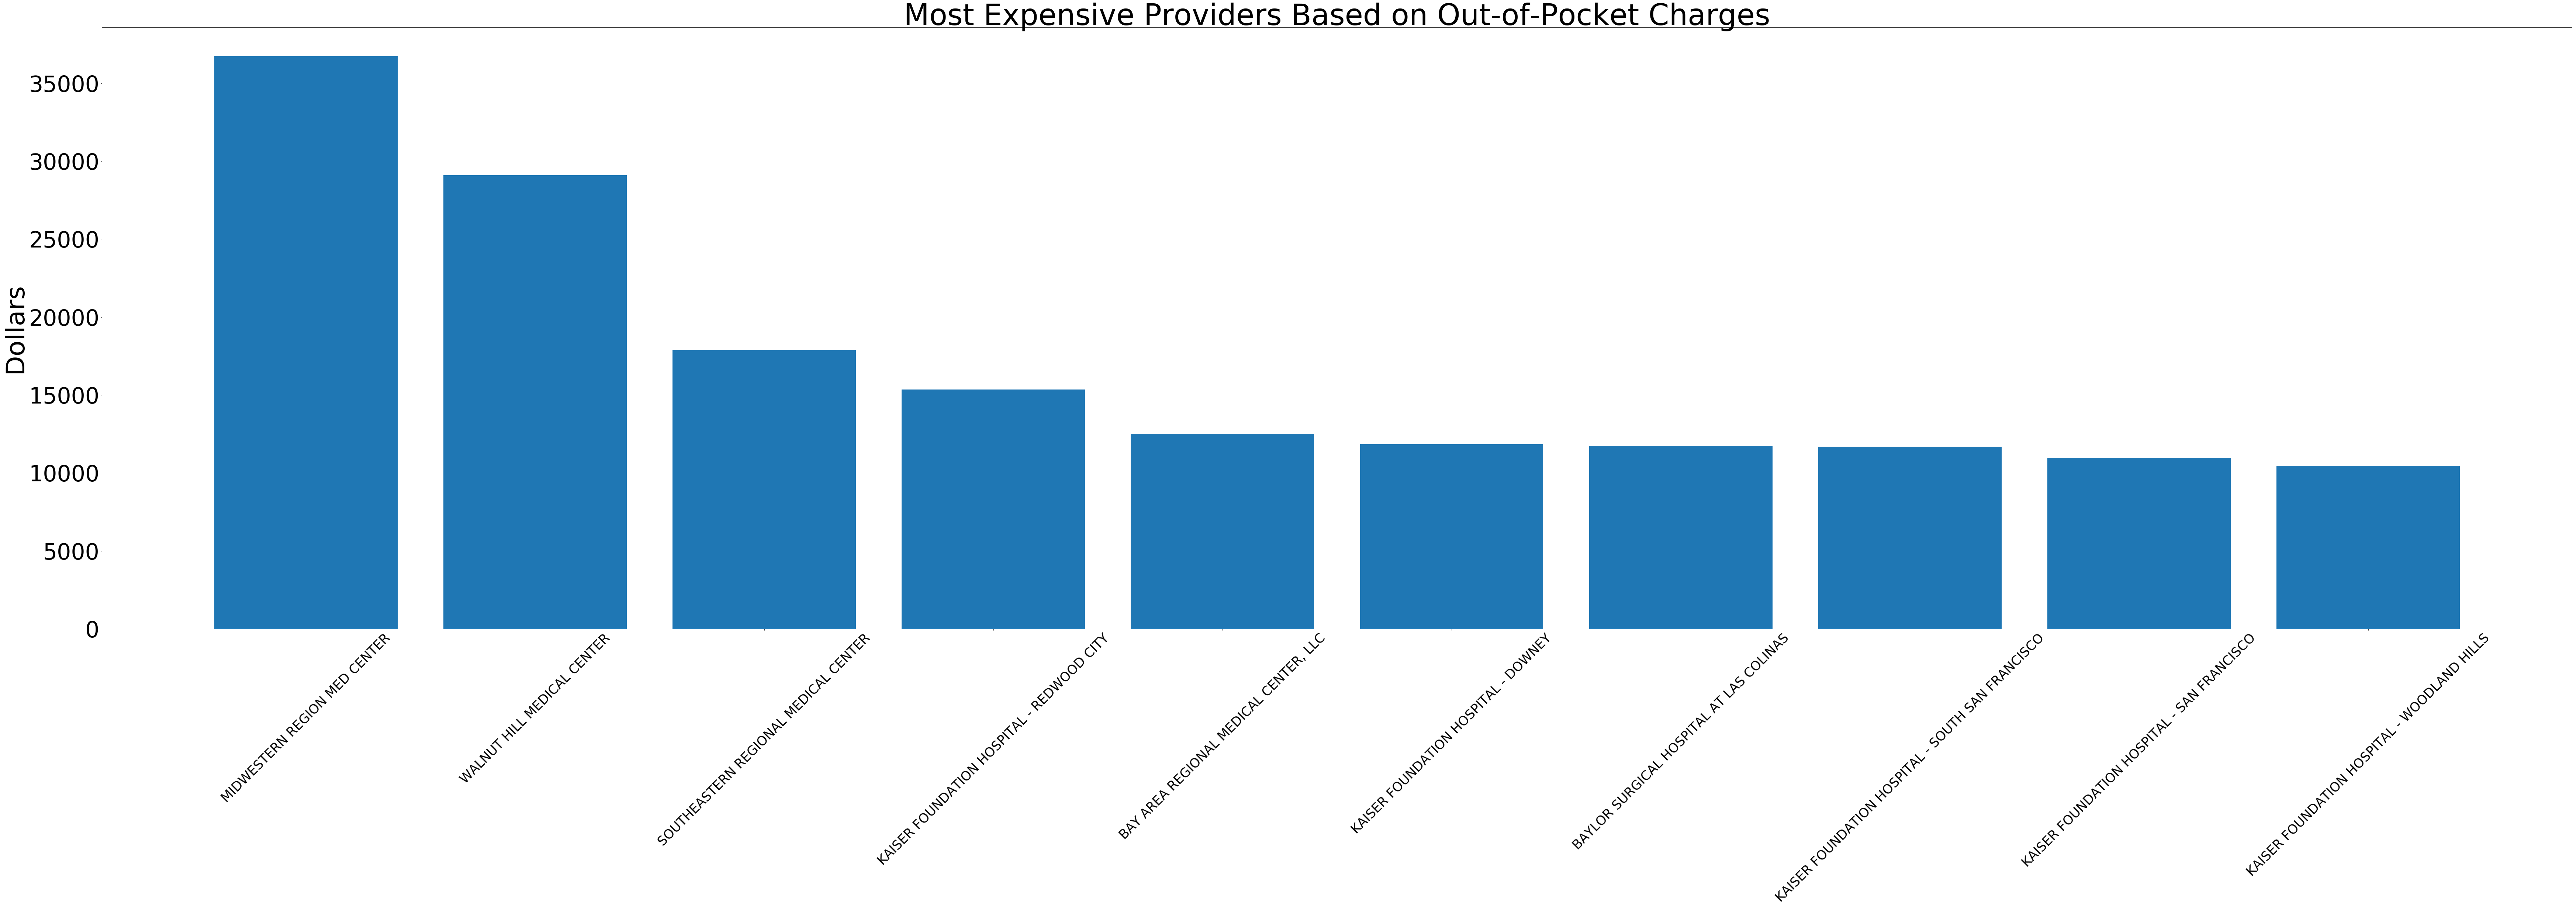

In [61]:
# len(avg_cost_group["average_covered_charges"])
import matplotlib.pyplot as plt
import numpy as np

# get the top 10 most expensive hospitals
plt.figure(1, figsize=(120,30))
x_axis = np.arange(0,10)
top_10_expensive = avg_cost_group["average_patient_payment"].sort_values(ascending=False).head(10)
tick_locations = [value for value in x_axis]
# print(list(top_10_expensive.reset_index()["provider_name"]))
plt.xticks(tick_locations, list(top_10_expensive.reset_index()["provider_name"]), size=35, rotation=45)
plt.yticks(size=60)

plt.ylabel("Dollars", size=70)
plt.title("Most Expensive Providers Based on Out-of-Pocket Charges", size=80)

# Show graph
plt.bar(x_axis, top_10_expensive)


<Container object of 10 artists>

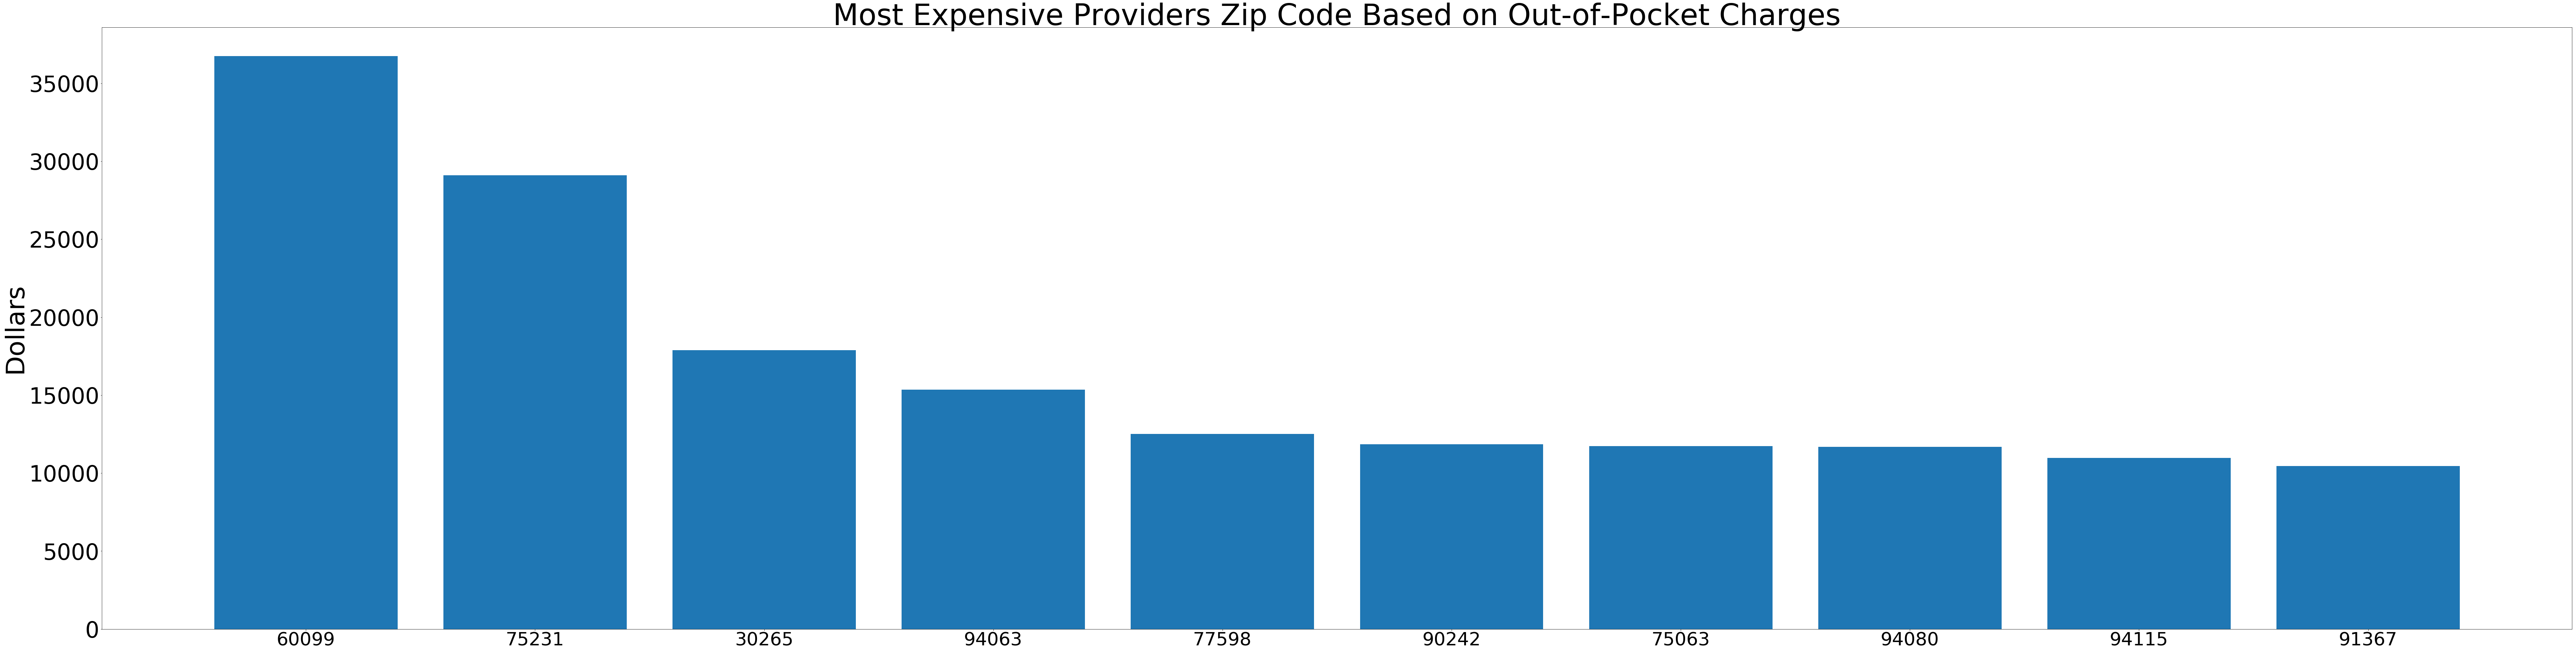

In [71]:
top_10_expensive_zip = avg_cost_group["average_patient_payment"].sort_values(ascending=False).head(10)

plt.figure(2, figsize=(120,30))
plt.xticks(tick_locations, list(top_10_expensive_zip.reset_index()["provider_zip_code"]), size=50)
plt.yticks(size=60)
plt.ylabel("Dollars", size=70)
plt.title("Most Expensive Providers Zip Code Based on Out-of-Pocket Charges", size=80)
plt.bar(x_axis, top_10_expensive)

# Avg Cost of Procedure in each state(John)

In [ ]:
#main_df['ACC'].groupby(main_df['Provider State']).head()
#state_office = df.groupby(['state', 'office_id']).agg({'sales': 'sum'})
#main_df.rename(columns = {list(main_df)[8]: 'TtlDis'}, inplace = True)
df_costs = main_df.groupby(['provider_state']).\
            aggregate({'average_covered_charges':'sum',\
                       'average_total_payments':'sum','total_discharges':'sum'})
df_costs['Ttl_billed_per_p']  = (df_costs['average_covered_charges']+df_costs['average_total_payments'])\
                                /df_costs['total_discharges']
df_costs['Ttl_covered_per_p'] =  df_costs['average_covered_charges']/df_costs['total_discharges']
df_costs['Ttl_oop_per_p'] = df_costs['average_total_payments']/df_costs['total_discharges']
df_costs.columns
#df_acc = main_df.groupby(['Provider State']).aggregate({'ACC':'sum'})
#df_atp = main_df.groupby(['Provider State']).aggregate({'ATP':'sum'})
#df_ttlD = main_df.groupby(['Provider State']).aggregate({'TtlDis':'sum'})
#df_ttlD.iloc[:,0:]

# Comparing procedure costs vs income in zip code(John)

# Data Exploration

## Dutch

In [ ]:
# Unique DRG definitions
main_df["drg_definition"].nunique()

In [ ]:
# Unique HRR Descriptions
main_df["hospital_referral_region_hrr_description"].nunique()

In [ ]:
# Unique providers
main_df["provider_id"].nunique()# Unique states (including the federal district D.C. (Washington D.C.))
main_df["provider_state"].nunique()

In [ ]:
# Providers per state
main_df.groupby("provider_state")["provider_id"].nunique()

In [ ]:
# US state map
## Total ACC, ATP and AMP by provider state
state_totals_df = main_df.groupby("provider_state", as_index = False).agg({"provider_id":"nunique",
                                                                           "average_covered_charges":"sum",
                                                                           "average_medicare_payments":"sum",
                                                                           "average_total_payments":"sum"})

cols = ["average_covered_charges","average_medicare_payments","average_total_payments"]
state_totals_df[cols] = state_totals_df[cols]/1000000

state_totals_df = state_totals_df.rename(columns={"provider_state":"State",
                                                  "provider_id":"Total providers",
                                                  "average_covered_charges":"ACC Total",
                                                  "average_medicare_payments":"AMP Total",
                                                  "average_total_payments":"ATP Total"
                                                 })

state_totals_df.head()

for col in state_totals_df.columns:
    state_totals_df[col] = state_totals_df[col].astype(str)

In [ ]:
scl = [[0.0, "rgb(242,240,247)"],[0.2, "rgb(218,218,235)"],[0.4, "rgb(188,189,220)"],
            [0.6, "rgb(158,154,200)"],[0.8, "rgb(117,107,177)"],[1.0, "rgb(84,39,143)"]]

In [ ]:
state_totals_df['text'] = state_totals_df["State"] + '<br>' +\
    "ACC"+state_totals_df["ACC Total"]+' AMP '+state_totals_df["AMP Total"]+'<br>'+\
    'ATP '+state_totals_df["ATP Total"]

In [ ]:
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_totals_df["State"],
        z = state_totals_df["Total providers"].astype(float),
        locationmode = 'USA-states',
        text = state_totals_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Millions USD")
        ) ]

layout = dict(
        title = '2015 US Medicare inpatient charges and payments by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )